<a href="https://colab.research.google.com/github/tytyty93/LazyProgrammer/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel,\
  preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

In [26]:
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

File ‘Food-5K.zip’ already there; not retrieving.



In [27]:
!unzip -qq -o Food-5K.zip

In [28]:
!ls

Food-5K  Food-5K.zip  __MACOSX	sample_data


In [39]:
!mv Food-5K/* .

mv: cannot stat 'Food-5K/*': No such file or directory


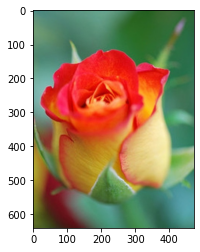

In [44]:
plt.imshow(image.load_img('training/0_808.jpg'));

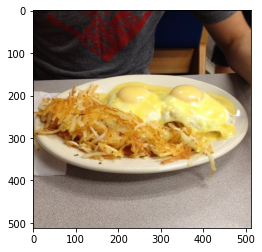

In [41]:
plt.imshow(image.load_img('training/1_808.jpg'));

In [45]:
!mkdir data

In [46]:
# Make directories to store the data Keras-style
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [47]:
# Move the images starting with 0 and ending with jpg to nonfood and vice versa
# Note: we will consider 'training' to be the train set
#       'validation' folder will be the test set
#       ignore the 'evaluation' set
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food  # Do not mistake the validation as moving into validation ah, its moving FROM validation to the test folder

In [48]:
train_path = 'data/train'
valid_path = 'data/test'

In [49]:
# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [200, 200]

In [50]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [51]:
# useful for getting number of classes as an input for K(The amount of Dense layers in the final output)
folders = glob(train_path + '/*')
folders

['data/train/food', 'data/train/nonfood']

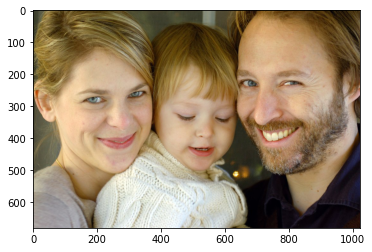

In [55]:
plt.imshow(image.load_img(np.random.choice(image_files)))

In [59]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [60]:
# map the data into feature vectors
# Notice that we don't add on the Dense layer here
x = Flatten()(ptm.output)  

In [61]:
# create a model object
model = Model(inputs=ptm.input, outputs=x)

In [62]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [63]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [65]:
batch_size = 128

# create generators
# Notice that we did not include the shuffle data as we are only transforming it.
# Also notice that the class mode is 'binary' as know that the targets are binary so theres no need to one-hot encode them  like
# passing the spare_categorical_crossentropy
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [82]:
Ntrain = len(image_files)
Nvalid = len(valid_image_files)

# Figure out the output size
feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3])) # Just predicting a random thing to get the output shape
D = feat.shape[1]

X_train = np.zeros((Ntrain, D))
Y_train = np.zeros(Ntrain)
X_valid = np.zeros((Nvalid, D))
Y_valid = np.zeros(Nvalid)

In [83]:
feat.shape[1]

18432

In [85]:
np.zeros((Ntrain,D)).shape

(3000, 18432)

In [86]:
# populate X_train and Y_train
i = 0
for x, y in train_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_train[i:i + sz] = features
  Y_train[i:i + sz] = y
  
  # increment i
  i += sz
  print(i)

  if i >= Ntrain:
    print('breaking now')
    break
print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000
breaking now
3000


In [87]:
# populate X_valid and Y_valid
i = 0
for x, y in valid_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_valid[i:i + sz] = features
  Y_valid[i:i + sz] = y
  
  # increment i
  i += sz

  if i >= Nvalid:
    print('breaking now')
    break
print(i)

breaking now
1000


In [88]:
X_train.max(), X_train.min()

(650.8262939453125, 0.0)

In [89]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_valid2 = scaler.transform(X_valid)

In [90]:
# Try the built-in logistic regression

from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(X_train2, Y_train)
print(logr.score(X_train2, Y_train))
print(logr.score(X_valid2, Y_valid))

1.0
0.979


In [93]:
# Do logistic regression in Tensorflow

i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(i, x)

In [94]:
linearmodel.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [96]:
# Can try both normalized and unnormalized data
r = linearmodel.fit(
    X_train, Y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_valid, Y_valid),
)

Epoch 1/10
24/24 [==============================] - 0s 17ms/step - loss: 1.4063 - accuracy: 0.9183 - val_loss: 0.4039 - val_accuracy: 0.9740
Epoch 2/10
24/24 [==============================] - 0s 11ms/step - loss: 0.1000 - accuracy: 0.9923 - val_loss: 0.2996 - val_accuracy: 0.9760
Epoch 3/10
24/24 [==============================] - 0s 12ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.2792 - val_accuracy: 0.9750
Epoch 4/10
24/24 [==============================] - 0s 11ms/step - loss: 2.8866e-05 - accuracy: 1.0000 - val_loss: 0.2974 - val_accuracy: 0.9740
Epoch 5/10
24/24 [==============================] - 0s 11ms/step - loss: 2.4616e-05 - accuracy: 1.0000 - val_loss: 0.2959 - val_accuracy: 0.9740
Epoch 6/10
24/24 [==============================] - 0s 11ms/step - loss: 1.2834e-05 - accuracy: 1.0000 - val_loss: 0.2941 - val_accuracy: 0.9730
Epoch 7/10
24/24 [==============================] - 0s 11ms/step - loss: 9.1906e-06 - accuracy: 1.0000 - val_loss: 0.2923 - val_accuracy: 0.97

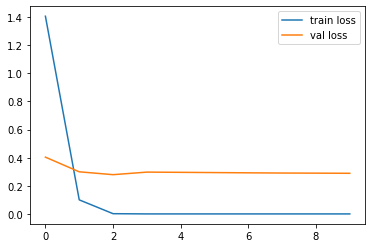

In [97]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

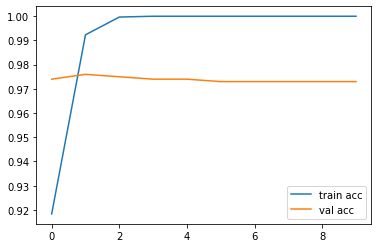

In [98]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()